# Aims
This notebook is created to 
- analyze temporal changes of climate variables
- create figures in main text and supplementary

In [1]:
# load packages
import numpy  as np
import pandas as pd
from DMC_functions import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# define the background
plt.style.use('ggplot')
plt.rc('xtick', direction='in', color='k')
plt.rc('ytick', direction='in', color='k')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='k', axisbelow=True, grid=True)

In [2]:
def standardized_data(month):
    '''
    month is the Dataframe
    '''
    import pandas as pd
    # set datatime
    month = month.set_index(pd.to_datetime(month['time']))
    # generate column 'year' and 'month'
    month['year'] = month.index.year
    month['month']= month.index.month
    # re-arrange columns
    month = month.reindex(columns=['year','month','HYZR', 'UYZR', 'MYZR', 'LYZR', 'LSR', 'NCR', 'NYR', 'UBR'])
    # rename index column
    month.index.name = 'time'

    return month

def convert_data(df):
    # convert the Year(int64) to Year(datetime64[ns])
    df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'], format='%Y')
    # set the datetime object as the index of the dataframe
    df = df.set_index('Unnamed: 0')
    df.index.name = 'Year'
    return df

def sel_time_range(df, start, end):
    # Usage: df = sel_time_range(df, '03-01-1991', '06-01-1997')
    # Note: MM-DD-YYYY
    mask = (df.index >= start) & (df.index <= end)
    df = df.loc[mask]
    return df

In [3]:
# climate
pre = pd.read_excel('../01-data/analysis/year_pre.xlsx')    # from 10km daily precipitation
aet = pd.read_excel('../01-data/analysis/year_aet.xlsx')    # from GLEAM 
# vegetation
lai = pd.read_excel('../01-data/analysis/year_lai.xlsx')    # from GIMMS
# runoff
wy  = pd.read_excel('../01-data/analysis/year_wyd.xlsx')    # from obseravtion

# pre-process data
pre = convert_data(pre) 
aet = convert_data(aet) 
lai = convert_data(lai)
wy  = convert_data(wy) 
# select the time range
start = '01-01-1982'
end   = '12-01-2013'
pre = sel_time_range(pre,  start=start, end=end)
aet = sel_time_range(aet,  start=start, end=end)
lai = sel_time_range(lai,  start=start, end=end)
wy  = sel_time_range(wy ,  start=start, end=end)
# effective precipitation
ep  = pre - aet
names = ['HYZR','UYZR','NCR', 'MYZR', 'LSR', 'LYZR']
order1 = ['(a)', '(c)', '(e)', '(g)', '(i)', '(k)']
order2 = ['(b)', '(d)', '(f)', '(h)', '(j)', '(l)']

tp = [13, 16, 15, 15, 14, 15] # is acquired from another jupyter notebook

## Climatological expectation 

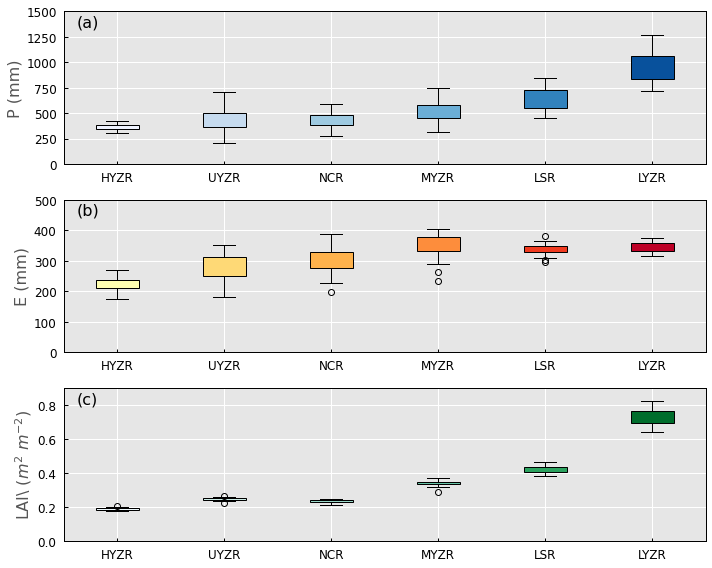

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# box settings
meanpointprops = dict(marker='x', markeredgecolor='black', markerfacecolor='black')
flierprops     = dict(marker='o', markerfacecolor='none',  markeredgecolor='black')

#################### P
colors = ['#eff3ff', '#c6dbef', '#9ecae1', '#6baed6', '#3182bd','#08519c']
bp = ax[0].boxplot(pre, positions=[1,2,3,4,5,6], widths=0.4, patch_artist=True, showmeans=True, meanprops=meanpointprops, flierprops=flierprops)
for patch, color in zip(bp['boxes'], colors): patch.set_facecolor(color) 
for median in bp['medians']: median.set(color ='red', linewidth = 0) 

ax[0].set_ylabel('P (mm)', fontsize=16)
ax[0].set_ylim([0,1500])
ax[0].text(0.02, 0.9, '(a)', color='k',  fontsize=16, transform=ax[0].transAxes)

#################### E
colors = ['#ffffb2', '#fed976', '#feb24c', '#fd8d3c', '#f03b20','#bd0026']
bp = ax[1].boxplot(aet, positions=[1,2,3,4,5,6], widths=0.4, patch_artist=True, showmeans=True, meanprops=meanpointprops, flierprops=flierprops)
for patch, color in zip(bp['boxes'], colors): patch.set_facecolor(color) 
for median in bp['medians']: median.set(color ='red', linewidth = 0) 

ax[1].set_ylabel('E (mm)', fontsize=16)
ax[1].set_ylim([0,500])
ax[1].text(0.02, 0.9, '(b)', color='k', fontsize=16, transform=ax[1].transAxes)


#################### LAI
colors = ['#edf8fb', '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f','#006d2c']
bp = ax[2].boxplot(lai, positions=[1,2,3,4,5,6], widths=0.4, patch_artist=True, showmeans=True, meanprops=meanpointprops, flierprops=flierprops)
for patch, color in zip(bp['boxes'], colors): patch.set_facecolor(color) 
for median in bp['medians']: median.set(color ='red', linewidth = 0) 

ax[2].set_ylabel('LAI\ '+'$(m^2\ m^{-2})$', fontsize=16)
ax[2].set_ylim([0,0.9])
ax[2].text(0.02, 0.9, '(c)', color='k',  fontsize=16, transform=ax[2].transAxes)

# x axis settings
for axs in ax:
    axs.set_xticks([1,2,3,4,5,6], pre.columns)
    axs.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('../03-res/02-figures/climate-means.png', dpi=300, bbox_inches='tight')

## Direction changes

In [17]:
import pymannkendall as mk
# create data
data = pre
# create slope
slope = np.zeros([5,6])
'''
# row 1: slop before tp; 
# ror 2: slop after tp; 
# row 3: slop difference;
'''
for i in np.arange(0,6):
    slope[0,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[0:int(tp[i]),i], alpha=0.1)[7]
    slope[1,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[int(tp[i]):,i], alpha=0.1)[7]
    slope[2,i] = slope[1,i] - slope[0,i]
    slope[3,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[0:int(tp[i]),i], alpha=0.1)[2]
    slope[4,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[int(tp[i]):,i], alpha=0.1)[2]

slope = pd.DataFrame(slope, index=['slope_bf','slope_af','dif', 'pvalue_bf','pvalue_af'], columns=names)
# copy data
slope_p = slope

print('pre directions', '\n', slope_p)

pre directions 
                HYZR       UYZR       NCR       MYZR        LSR       LYZR
slope_bf  -4.789803   7.065344  3.699609   7.500947  11.840233  17.730793
slope_af  -0.921946 -12.347001 -5.050911 -11.262364 -10.012340 -18.036952
dif        3.867856 -19.412345 -8.750519 -18.763311 -21.852572 -35.767746
pvalue_bf  0.192616   0.620691  0.912814   0.273561   0.200128   0.154630
pvalue_af  0.404670   0.234955  0.095747   0.006026   0.127477   0.027377


In [18]:
# create data
data = aet
# create slope
slope = np.zeros([5,6])
'''
# row 1: slop before tp; 
# ror 2: slop after tp; 
# row 3: slop difference;
'''
for i in np.arange(0,6):
    slope[0,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[0:int(tp[i]),i], alpha=0.1)[7]
    slope[1,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[int(tp[i]):,i], alpha=0.1)[7]
    slope[2,i] = slope[1,i] - slope[0,i]
    slope[3,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[0:int(tp[i]),i], alpha=0.1)[2]
    slope[4,i] = mk.trend_free_pre_whitening_modification_test(data.iloc[int(tp[i]):,i], alpha=0.1)[2]

slope = pd.DataFrame(slope, index=['slope_bf','slope_af','dif', 'pvalue_bf','pvalue_af'], columns=names)
# copy data
slope_aet = slope

print('aet directions', '\n', slope_aet)

aet directions 
                HYZR      UYZR       NCR      MYZR       LSR      LYZR
slope_bf   2.416973  3.358281  4.242525  6.890722  3.227054  2.653672
slope_af   1.281792  0.513763  0.866399 -0.661646  1.237359  1.290120
dif       -1.135182 -2.844518 -3.376126 -7.552367 -1.989695 -1.363553
pvalue_bf  0.450670  0.060038  0.037497  0.008595  0.017343  0.011793
pvalue_af  0.324712  0.766525  0.752642  0.344418  0.063787  0.499461


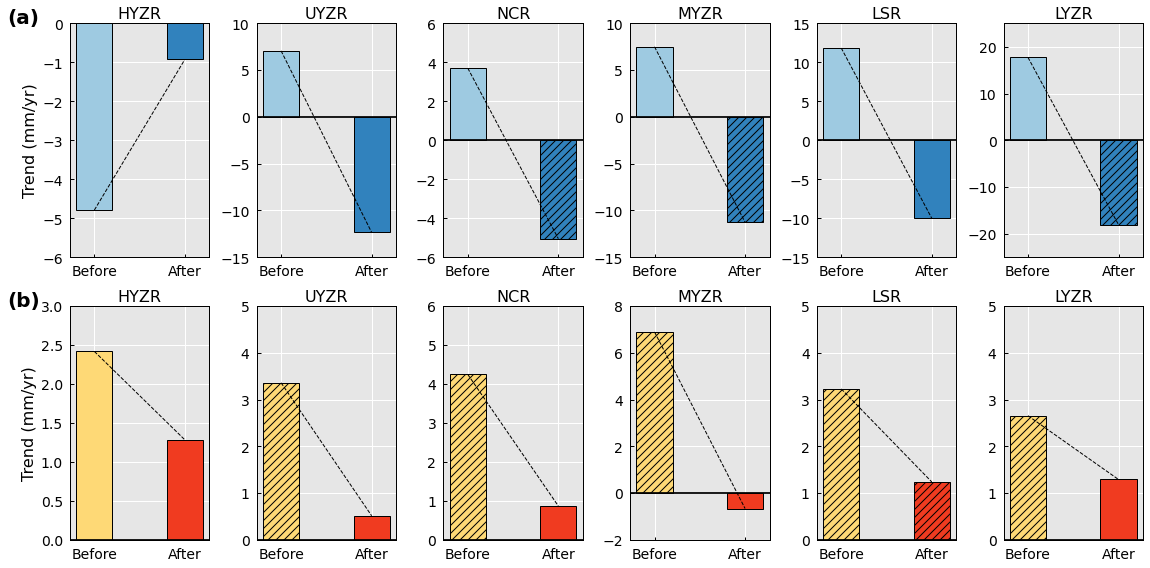

In [35]:
fig = plt.figure(figsize=(16,8))
left = 1; right = 2; width = 0.4

for i in range(len(names)):

    ########################### (pre)
    # ylim
    y_up = [ 0,  10,  6, 10,   15,  25]
    y_lw = [-6, -15, -6, -15, -15, -25]
    abs_y = np.array(y_up) - np.array(y_lw)
    # colors
    colors = ['#9ecae1', '#3182bd']
    ax = plt.subplot(2,6,i+1)
    # copy data
    slope = slope_p
    # plot
    if slope.iloc[3,i]<0.10:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=colors[0], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=colors[0], edgecolor='k', lw=1)
    if slope.iloc[4,i]<0.10:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=colors[1], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=colors[1], edgecolor='k', lw=1)
    # plot line
    plt.plot([left, right], [slope.iloc[0,i], slope.iloc[1,i]], 'k--', markersize=10, linewidth=1)     
    # add information
    plt.title(label=names[i], pad=5, fontsize=16)
    #########################################
    plt.axhline(y=0, ls='-', c='k')
    #########################################
    plt.ylim([y_lw[i], y_up[i]])
    # save the label infomation in the left and bottom 
    if i == 0:
        plt.ylabel('Trend (mm/yr)', fontsize=16, color='k')
    plt.xticks([left,right], ['Before','After'],)
    
    # add title
    if i == 0:
        ax.text(-0.45, 1.0, '(a)', color='k', fontsize=20, weight='bold', transform=ax.transAxes)

    ########################### (aet)
    ax = plt.subplot(2,6,i+7)
    # ylim
    y_up = [3,  5,  6,  8, 5, 5]
    y_lw = [0,  0,  0, -2, 0, 0]
    abs_y = np.array(y_up) - np.array(y_lw)
    # colors
    colors = ['#fed976', '#f03b20']
    # copy data
    slope = slope_aet
    # plot
    if slope.iloc[3,i]<0.10:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=colors[0], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([left], slope.iloc[0:1,i], width=width, color=colors[0], edgecolor='k', lw=1)
    if slope.iloc[4,i]<0.10:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=colors[1], edgecolor='k', lw=1, hatch='///')
    else:
        plt.bar([right], slope.iloc[1:2,i], width=width, color=colors[1], edgecolor='k', lw=1)
    # plot line
    plt.plot([left, right], [slope.iloc[0,i], slope.iloc[1,i]], 'k--', markersize=10, linewidth=1)     
    # add information
    plt.title(label=names[i], pad=5, fontsize=16)
    #########################################
    plt.axhline(y=0, ls='-', c='k')
    #########################################
    plt.ylim([y_lw[i], y_up[i]])
    # save the label infomation in the left and bottom 
    if i == 0:
        plt.ylabel('Trend (mm/yr)', fontsize=16, color='k')
    plt.xticks([left,right], ['Before','After'])
    
    # add title
    if i == 0:
        ax.text(-0.45, 1.0, '(b)', color='k', fontsize=20, weight='bold', transform=ax.transAxes)
      
    for ax in fig.axes:
        ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('../03-res/02-figures/P_AET_diections.png', dpi=300, bbox_inches='tight')

## Temporal changes

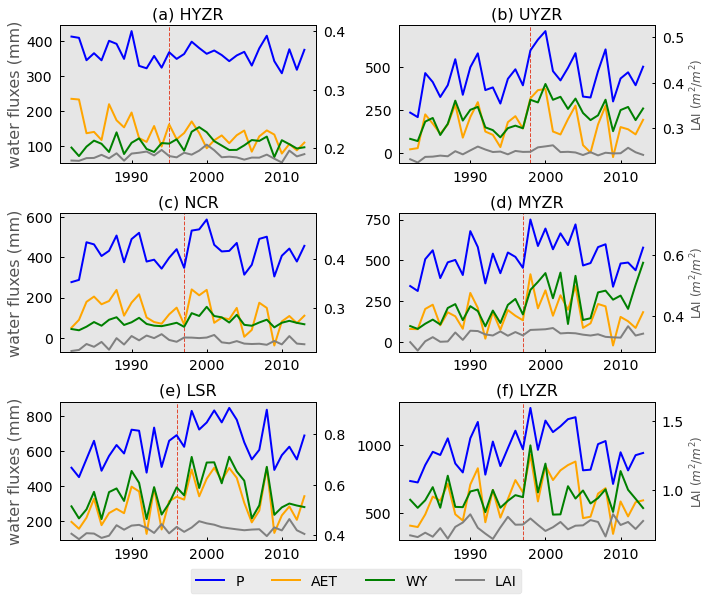

In [36]:
plt.style.use('seaborn-notebook')
fig = plt.figure(figsize=[10,8])
order = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
TP = [1995, 1998, 1997, 1997, 1996, 1997]

for i in range(len(names)):
    # plot
    ax = plt.subplot(3,2,i+1)
    # plot tp
    ax.axvline(x=TP[i], ls='--', lw=1)
    # close grids
    ax.grid(False)
    # data
    x  = np.arange(1982,2014); 
    ts_pre = pre[names[i]]; ts_aet = ep[names[i]]
    ts_wy  = wy[names[i]] ; ts_lai = lai[names[i]]
    ts_lai = lai[names[i]]

    # plot hydrological fluxes: pre, aet, wy and ep
    ln1 = ax.plot(x, ts_pre, '-', lw=2.0,  color='blue',   label='P')
    ln2 = ax.plot(x, ts_aet, '-', lw=2.0,  color='orange', label='AET')
    ln3 = ax.plot(x, ts_wy , '-', lw=2.0,  color='green',  label='WY')
    
    # plot vegetation
    ax2 = ax.twinx()
    ln5 = ax2.plot(x, ts_lai , '-', lw=2.0,  color='grey', label='LAI')
    ax2.grid(False)
    ax2.set_ylim(ymax=2*np.max(ts_lai))
    
    ax.set_title(order[i] + ' ' + names[i], fontsize=16)

    if i == 0 or i==2 or i==4:
        ax.set_ylabel('water fluxes (mm)', fontsize=16)
    else:
        ax2.set_ylabel(r'LAI ' + r'$(m^2/m^2)$', fontsize=12)

    if i == 5:
        lns = ln1 + ln2 + ln3 + ln5
        labs = [l.get_label() for l in lns]
        fig.legend(lns, labs, ncol=5, loc='lower center', bbox_to_anchor=(0.5, -0.05), fontsize=14)

    for ax in fig.axes:
        ax.tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('../03-res/02-figures/time-series.png', dpi=300, bbox_inches='tight')